In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import torch
torch.set_num_threads(1)

import colbert.warp.setup

from colbert.warp.config import WARPRunConfig
from colbert.warp.searcher import WARPSearcher
from colbert.warp.data.queries import WARPQueries

from colbert.warp.onnx_model import (
    XTROnnxQuantization,
    XTROnnxConfig,
)

from colbert.utils.tracker import ExecutionTracker

#> Running WARP Setup Code.


In [6]:
onnx_config = XTROnnxConfig(quantization=XTROnnxQuantization.NONE, opset_version=17)
config = WARPRunConfig(
    nranks=4,
    dataset="lotte",
    collection="writing",
    type_="search",
    datasplit="test",
    nbits=4,
    k=100,
    onnx=onnx_config
)
searcher = WARPSearcher(config)
queries = WARPQueries(config)

[Jul 11, 21:08:14] #> Loading collection...
0M 
#> Loading XTR ONNX model from '/Users/jlscheerer/xtr/models/onnx/xtr.v=17.batch=1.onnx' (418.75MB)
[Jul 11, 21:08:16] #> Loading buckets...
[Jul 11, 21:08:16] #> Loading codec...


2024-07-11 21:08:15.238703 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:encoder.embed_tokens.weight, shape: {32128,768}
2024-07-11 21:08:15.239087 [W:onnxruntime:, coreml_execution_provider.cc:104 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 76 number of nodes in the graph: 531 number of nodes supported by CoreML: 411
2024-07-11 21:08:16.087875 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-07-11 21:08:16.087883 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


[Jul 11, 21:08:17] #> Loading repacked residuals...
[Jul 11, 21:08:18] #> Loading the queries from /Users/jlscheerer/future/datasets/writing/test/questions.search.tsv ...
[Jul 11, 21:08:18] #> Got 1071 queries. All QIDs are unique.



In [5]:
tracker = ExecutionTracker(name="XTR/WARP", steps=["Query Encoding", "Candidate Generation", "top-k Precompute",
                                                   "Decompression", "Lookup", "Build Matrix"])
ranking = searcher.search_all(queries, k=5, batched=False, tracker=tracker)

tracker.display(["Candidate Generation", "top-k Precompute", "Decompression", "Lookup", "Build Matrix"])
print("S@5:", round(ranking.evaluate(queries.qrels, k=5)["metrics"]["Success@5"], 3) * 100)

 11%|███████████▏                                                                                     | 123/1071 [00:06<00:51, 18.28it/s]


KeyboardInterrupt: 

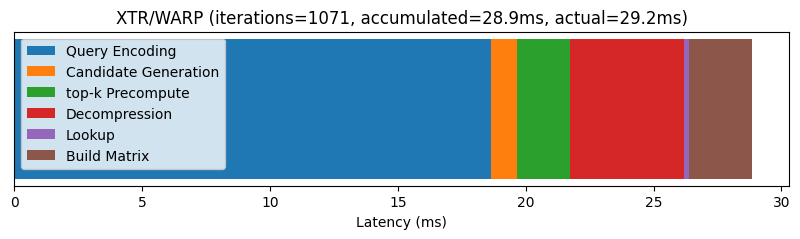

In [4]:
tracker.display()

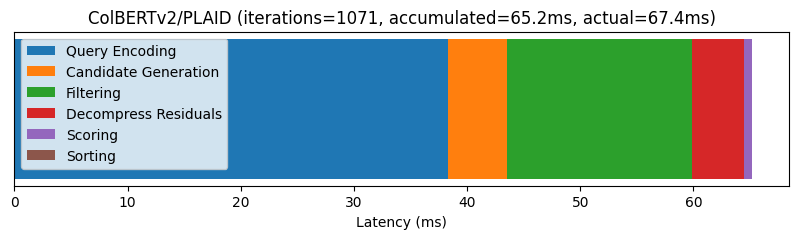

In [10]:
cb_tracker.display()

[Jul 11, 20:27:28] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 11, 20:27:28] #> Loading collection...
0M 
[Jul 11, 20:27:32] #> Loading codec...
[Jul 11, 20:27:32] #> Loading IVF...
[Jul 11, 20:27:32] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1063.26it/s]

[Jul 11, 20:27:32] #> Loading codes and residuals...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.68it/s]

[Jul 11, 20:27:34] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Jul 11, 20:27:34] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1071/1071 [01:12<00:00, 14.79it/s]


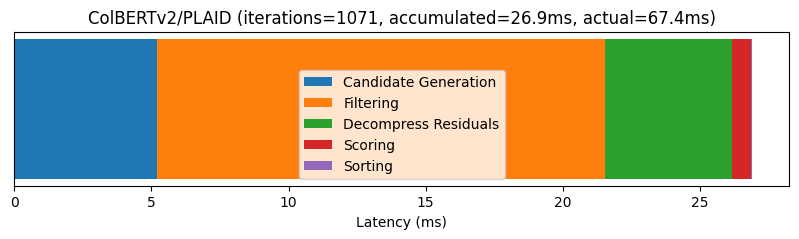

In [4]:
# TODO(jlscheerer) ColBERTv2/PLAID evaluation
# TODO(jlscheerer) This is not entirely clean because we should create an index dedicated to ColBERTv2/PLAID
from colbert.searcher import Searcher
from colbert.modeling.colbert import ColBERT
from tqdm import tqdm

ColBERT.try_load_torch_extensions(use_gpu=False)

cb_searcher = Searcher(index=config.index_name, config=config.colbert(), index_root=config.index_root, warp_engine=False)
cb_tracker = ExecutionTracker(name="ColBERTv2/PLAID", steps=["Query Encoding", "Candidate Generation", "Filtering", 
                                                             "Decompress Residuals", "Scoring", "Sorting"])

for qid, qtext in tqdm(queries):
    cb_tracker.next_iteration()
    cb_searcher.search(qtext, k=5, tracker=cb_tracker)
    cb_tracker.end_iteration()

cb_tracker.display(["Candidate Generation", "Filtering", "Decompress Residuals", "Scoring", "Sorting"])